# Lecture 5 - Bayesian Normal Linear Regression and Hypothesis Testing

## Today's Learning Objectives

1. Describe the basics of Bayesian Normal linear regression.
2. Explore and contrast Bayesian Normal linear regression versus Ordinary Least-Squares (OLS).
3. Retake the concept of the posterior credible interval in a Beta-Binomial framework.
4. Introduce one-sided hypothesis testing in a Beta-Binomial framework.
5. Relate the posterior credible interval with the two-sided hypothesis in a Beta-Binomial framework.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 6)
library(bayesrules)
library(ggplot2)
library(tidyverse)
library(rstantools)
library(cowplot)
library(broom)
library(extraDistr)
library(rstan)
library(broom.mixed)
library(bayesplot)
library(wesanderson)

── Attaching core tidyverse packages ─────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ───────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is rstantools version 2.4.0


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘extraDistr’


The following object is masked from ‘package:purrr’:

    rdunif


Loading required package: StanHeaders


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).


## Previously...

We have explored the Bayes' rule via probability theory with **discrete and continuous variables**. Note we expanded this approach to the Beta-Binomial and Gamma-Poisson models, a conjunction of continuous and discrete distributions for our prior and likelihood components, respectively. We already defined an interval estimate in a Bayesian framework: **the posterior credible interval**. Nonetheless, we have not discussed how to perform Bayesian hypothesis testing yet.

Additionally, the bike-share ({doc}`lecture4_MCMC_Poisson_Gamma_Normal`) and baseball (`lab2`) problems provided further insights into something we have not formally defined: **Bayesian regression**.

Therefore, it is time to check **Bayesian hypothesis testing** and **Normal regression**.

## 1. Bayesian Normal Linear Regression

Even though we already worked with two cases that paved the way (baseball and bikeshare data) to regression analysis, we have not formally introduced the concept of **Bayesian regression**. However, now that we have the Bayesian inference foundations, we can start with regression modelling in variable frameworks we explored in **DSCI 561** and **562**.

The general ideas remain: 

- We need to assess the association (or causation if that is the case) between a response $Y$ and our $k$ regressors $X_1, \dots, X_k$.
- Or, we need to predict a new $Y'$ with our trained model.

### 1.1. The `bikes` Dataset

The `bayesrules` package contains another more reduced version of the dataset we used for our case in [`lecture4`](https://ubc-mds.github.io/DSCI_553_stat-inf-2/notes/lecture4_MCMC_Poisson_Gamma_Normal.html). According to the package's documentation, the description is the following:

> *Data on ridership among registered members of the Capital Bikeshare service in Washington, D.C.*

**The dataset contains $n = 500$ observations and thirteen variables.**

In [2]:
bikes

date,season,year,month,day_of_week,weekend,holiday,temp_actual,temp_feel,humidity,windspeed,weather_cat,rides
<date>,<fct>,<int>,<fct>,<fct>,<lgl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
2011-01-01,winter,2011,Jan,Sat,TRUE,no,57.39952,64.72625,80.5833,10.74988,categ2,654
2011-01-03,winter,2011,Jan,Mon,FALSE,no,46.49166,49.04645,43.7273,16.63670,categ1,1229
2011-01-04,winter,2011,Jan,Tue,FALSE,no,46.76000,51.09098,59.0435,10.73983,categ1,1454
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2012-12-29,winter,2012,Dec,Sat,TRUE,no,50.69598,53.81600,75.2917,8.333661,categ2,1182
2012-12-30,winter,2012,Dec,Sun,TRUE,no,50.88048,52.85300,48.3333,23.500518,categ1,1432
2012-12-31,winter,2012,Dec,Mon,FALSE,no,47.92848,52.11383,57.7500,10.374682,categ2,2290


We will work with the following variables:

- `weekend`: Whether or not the date falls on a weekend (`TRUE` or `FALSE`). It is a **binary variable** and one of the **regressors**.
- `temp_feel`: What the temperature feels like (degrees Fahrenheit). It is a **continuous variable** and one of the **regressors**.
- `rides`: The number of bikeshare rides. It is an integer-type variable and our **response**.

In [3]:
bikeshare_data <- bikes |>
  select(weekend, temp_feel, rides)
bikeshare_data

weekend,temp_feel,rides
<lgl>,<dbl>,<int>
TRUE,64.72625,654
FALSE,49.04645,1229
FALSE,51.09098,1454
⋮,⋮,⋮
TRUE,53.81600,1182
TRUE,52.85300,1432
FALSE,52.11383,2290


```{admonition} Main statistical inquiries
Suppose we are interested in the following statistical inquiries:

1. How are `weekend` and `temp_feel` associated with `rides`?
2. Is there a numerical result that can quantify this association?
3. Can we predict the number of `rides` during a weekend with 75 degrees Fahrenheit? What is the prediction interval?
```

```{exercise}
:label: lecture5-q1

Let us retake **DSCI 562** topics under a frequentist approach; what regression modelling can approach the above inquiries?

**A.** A generalized linear model (GLM) such as Multinomial regression.

**B.** A GLM such as Ordinal Logistic regression.

**C.** A GLM such as Poisson regression.

**D.** Ordinary Least-squares (OLS).
```

```{figure} ../img/Poisson_and_Normal.png
:height: 350px
:name: Poisson_and_Normal
```

*Source: [Univariate Distribution Relationships](http://www.math.wm.edu/~leemis/chart/UDR/UDR.html)*

### 1.2. Exploratory Data Analysis

Let us make a quick exploratory data analysis on `bikeshare_data`: `rides` versus `weekend` and `rides` versus `temp_feel`.

In [4]:
options(repr.plot.height = 9, repr.plot.width = 12)

weekend_boxplots <- bikeshare_data |>
  ggplot(aes(weekend, rides)) +
  geom_boxplot(aes(fill = weekend)) +
  labs(y = "Bike Rides", x = "Weekend") +
  ggtitle("Side-by-Side Boxplots") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "none"
  ) + 
  scale_fill_manual(values = wes_palette(n = 3, name = "GrandBudapest1"))

Note the bike rides tend to be less during weekends.

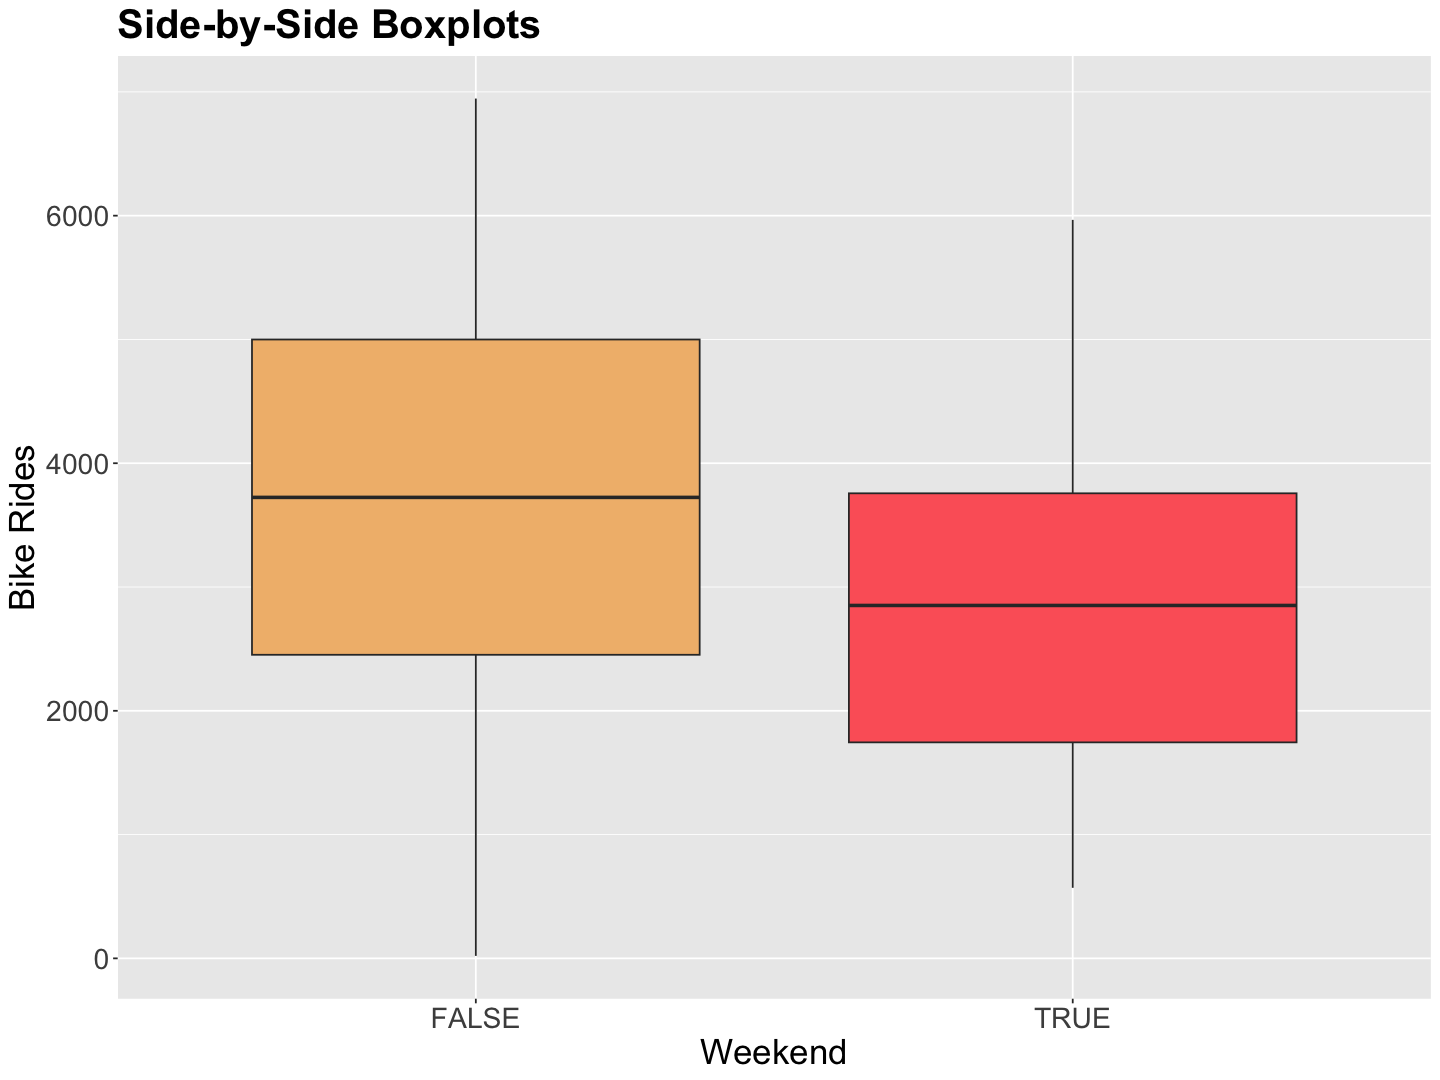

In [5]:
weekend_boxplots

If we fit an OLS simple linear regression of `temp_feel` versus `rides`, the `rides` seem to increase along with temperature linearly.

In [6]:
bikeshare_data_scatterplot <- ggplot(bikeshare_data, aes(
  x = temp_feel, y = rides
)) +
  geom_point(color = "blue") +
  labs(y = "Bike Rides", x = "Temperature (F)") +
  geom_smooth(aes(temp_feel, rides), method = "lm", se = FALSE, colour = "red", formula = "y ~ x") +
  ggtitle("Scatterplot with OLS Regression Fitted Line") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  )

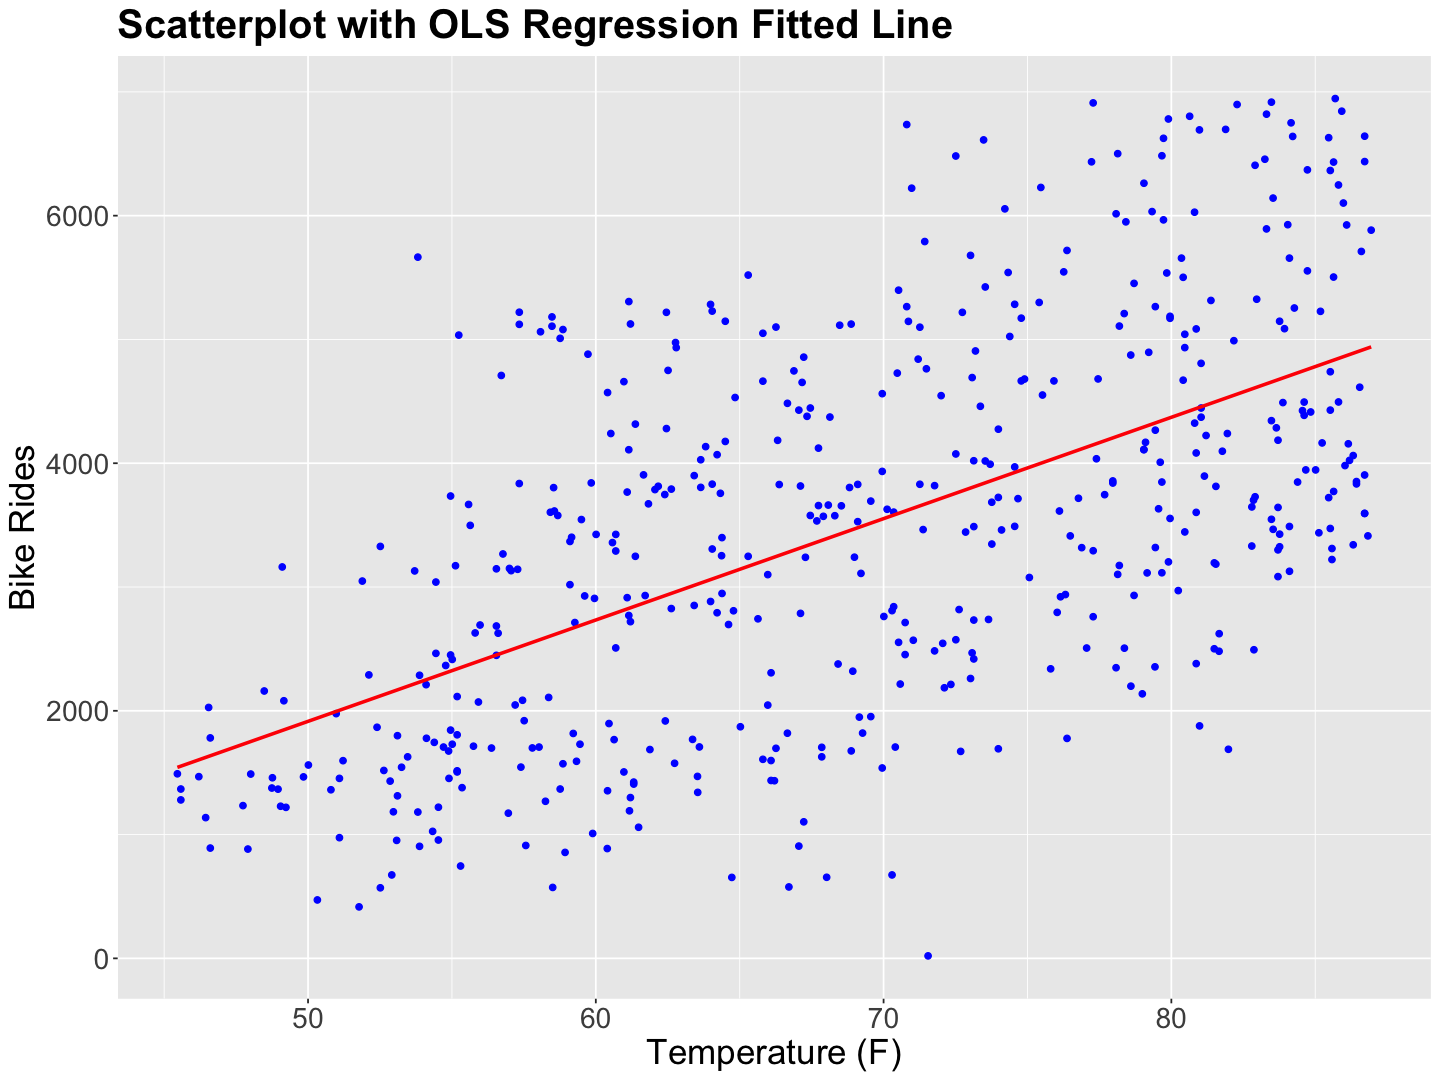

In [7]:
bikeshare_data_scatterplot

### 1.3. Fitting a Frequentist OLS Regression Model

First, **for the sake of approach comparison with $i = 1 , \dots , n$**; we will estimate an OLS regression model. In this case (for the $i$th observation) let $Y_i$ be `rides`, $X_{i,1}$ be `temp_feel`, and

```{math}
\begin{equation*}
X_{i, 2} =
\begin{cases}
1 \; \; \; \; \mbox{if } \texttt{weekend} \mbox{ is } \texttt{TRUE},\\
0 \; \; \; \; 	\mbox{otherwise;}
\end{cases}
\end{equation*}
```

the OLS model is:

$$
Y_i = \beta_0 + \beta_1 X_{i, 1} + \beta_2 X_{i, 2} + \varepsilon_i.
$$

With the following assumptions:

```{math}
\begin{gather*}
\mathbb{E}(\varepsilon_i) = 0 \\
\text{Var}(\varepsilon_i) = \sigma^2 \\
\varepsilon_i \sim \mathcal{N}(0, \sigma^2) \\
\varepsilon_i \perp \!\!\! \perp \varepsilon_k \; \; \; \; \text{for} \; i \neq k  \; \; \; \; \text{(independence)}. 
\end{gather*}
```

In [8]:
rides_OLS <- lm(rides ~ temp_feel + weekend, data = bikeshare_data)
tidy(rides_OLS, conf.int = TRUE) |> 
  mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1873.751,351.790,-5.326,0,-2564.929,-1182.573
temp_feel,80.347,4.971,16.162,0,70.580,90.115
weekendTRUE,-707.621,123.644,-5.723,0,-950.550,-464.693


```{attention}
**From the frequentist point of view**, the output indicates statistically significant coefficients. Note the estimated intercept is negative, which does not make sense for `rides`. **We could fix this in our Bayesian approach.**
```

### 1.4.  Setting up a Bayesian Regression Model

Now that `rides_OLS` is all done, let us start our Bayesian model. **Assuming response normality**, we have the following:

$$Y_i \sim \mathcal{N}(\mu_i = \beta_0 + \beta_1 X_{i, 1} + \beta_2 X_{i, 2}, \sigma^2)$$

```{important}
Each $Y_i$ will have its own mean $\mu_i$. This mean is the **systematic component** of the regression model. Furthermore, all responses will share a common variance $\sigma^2$ (**analogous to the error terms in OLS**).
```

**For the prior specification**, we will proceed as follows:

- $\beta_0 \sim \text{Gamma}(\alpha =  7.5, \beta = 1)$.
- $\beta_1 \sim \mathcal{N}(\mu_{\beta_1} = 0, \sigma_{\beta_1}^2 = 1000^2)$.
- $\beta_2 \sim \mathcal{N}(\mu_{\beta_2} = 0, \sigma_{\beta_2}^2 = 1000^2)$.
- $\sigma \sim \mathrm{IG}(\eta = 0.001, \lambda = 0.001)$, this is the [Inverse Gamma distribution](http://www.math.wm.edu/~leemis/chart/UDR/PDFs/Invertedgamma.pdf) parametrized by *shape* $\eta = 0.001$ and *rate* $\lambda = 0.001$. This prior distribution is a popular choice for $\sigma > 0$. The `Stan` syntax is available [here](https://mc-stan.org/docs/functions-reference/inverse-gamma-distribution.html).

```{attention}
We have to stress the following:

- For these prior specifications, we assume that the mean of the $\beta_j$ ($j = 1, 2$) is $0$, since we do not know if the variable $X_{i,j}$ has any association with $Y_i$. We will use a large variance (i.e, $\sigma_{\beta_j}^2 = 1000^2$) on the coefficients **to reflect PRIOR uncertainty**.
- We also specify a nonnegative prior distribution (i.e., **Inverse Gamma**) for the common variance of the error terms $\sigma^2 > 0$.
- The nature of `rides` is non-negative. Hence, a Gamma prior on $\beta_0$ makes more sense than a Normal. **Its hyperparameters are chosen to reflect our uncertainty in this intercept.**

The density plots for these priors are shown below.
```

In [9]:
# Plotting Gamma prior for a_w
prior_gamma_beta_0 <- ggplot() +
  xlim(0, 20) +
  ylim(0, 0.2) +
  geom_function(fun = dgamma, args = list(shape = 7.5, rate = 1), linewidth = 2) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(beta["0"])) +
  ggtitle(expression("Prior Distribution for Intercept"))

# Plotting Normal prior for regression coefficients
prior_gamma_beta_j <- ggplot() +
  xlim(-4000, 4000) +
  ylim(0, 0.0004) +
  geom_function(fun = dnorm, args = list(mean = 0, sd = 1000), linewidth = 2) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(beta["j"])) +
  ggtitle(expression("Prior Distribution for Regression Coefficients"))

# Plotting Inverted Gamma prior for common variance
prior_inverted_gamma_sigma_sq <- ggplot() +
  xlim(0, 40) +
  ylim(0, 0.003) +
  geom_function(fun = dinvgamma, args = list(alpha = 0.001, beta = 0.001), linewidth = 2) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(sigma)) +
  ggtitle(expression("Prior Distribution for Common Standard Deviation"))

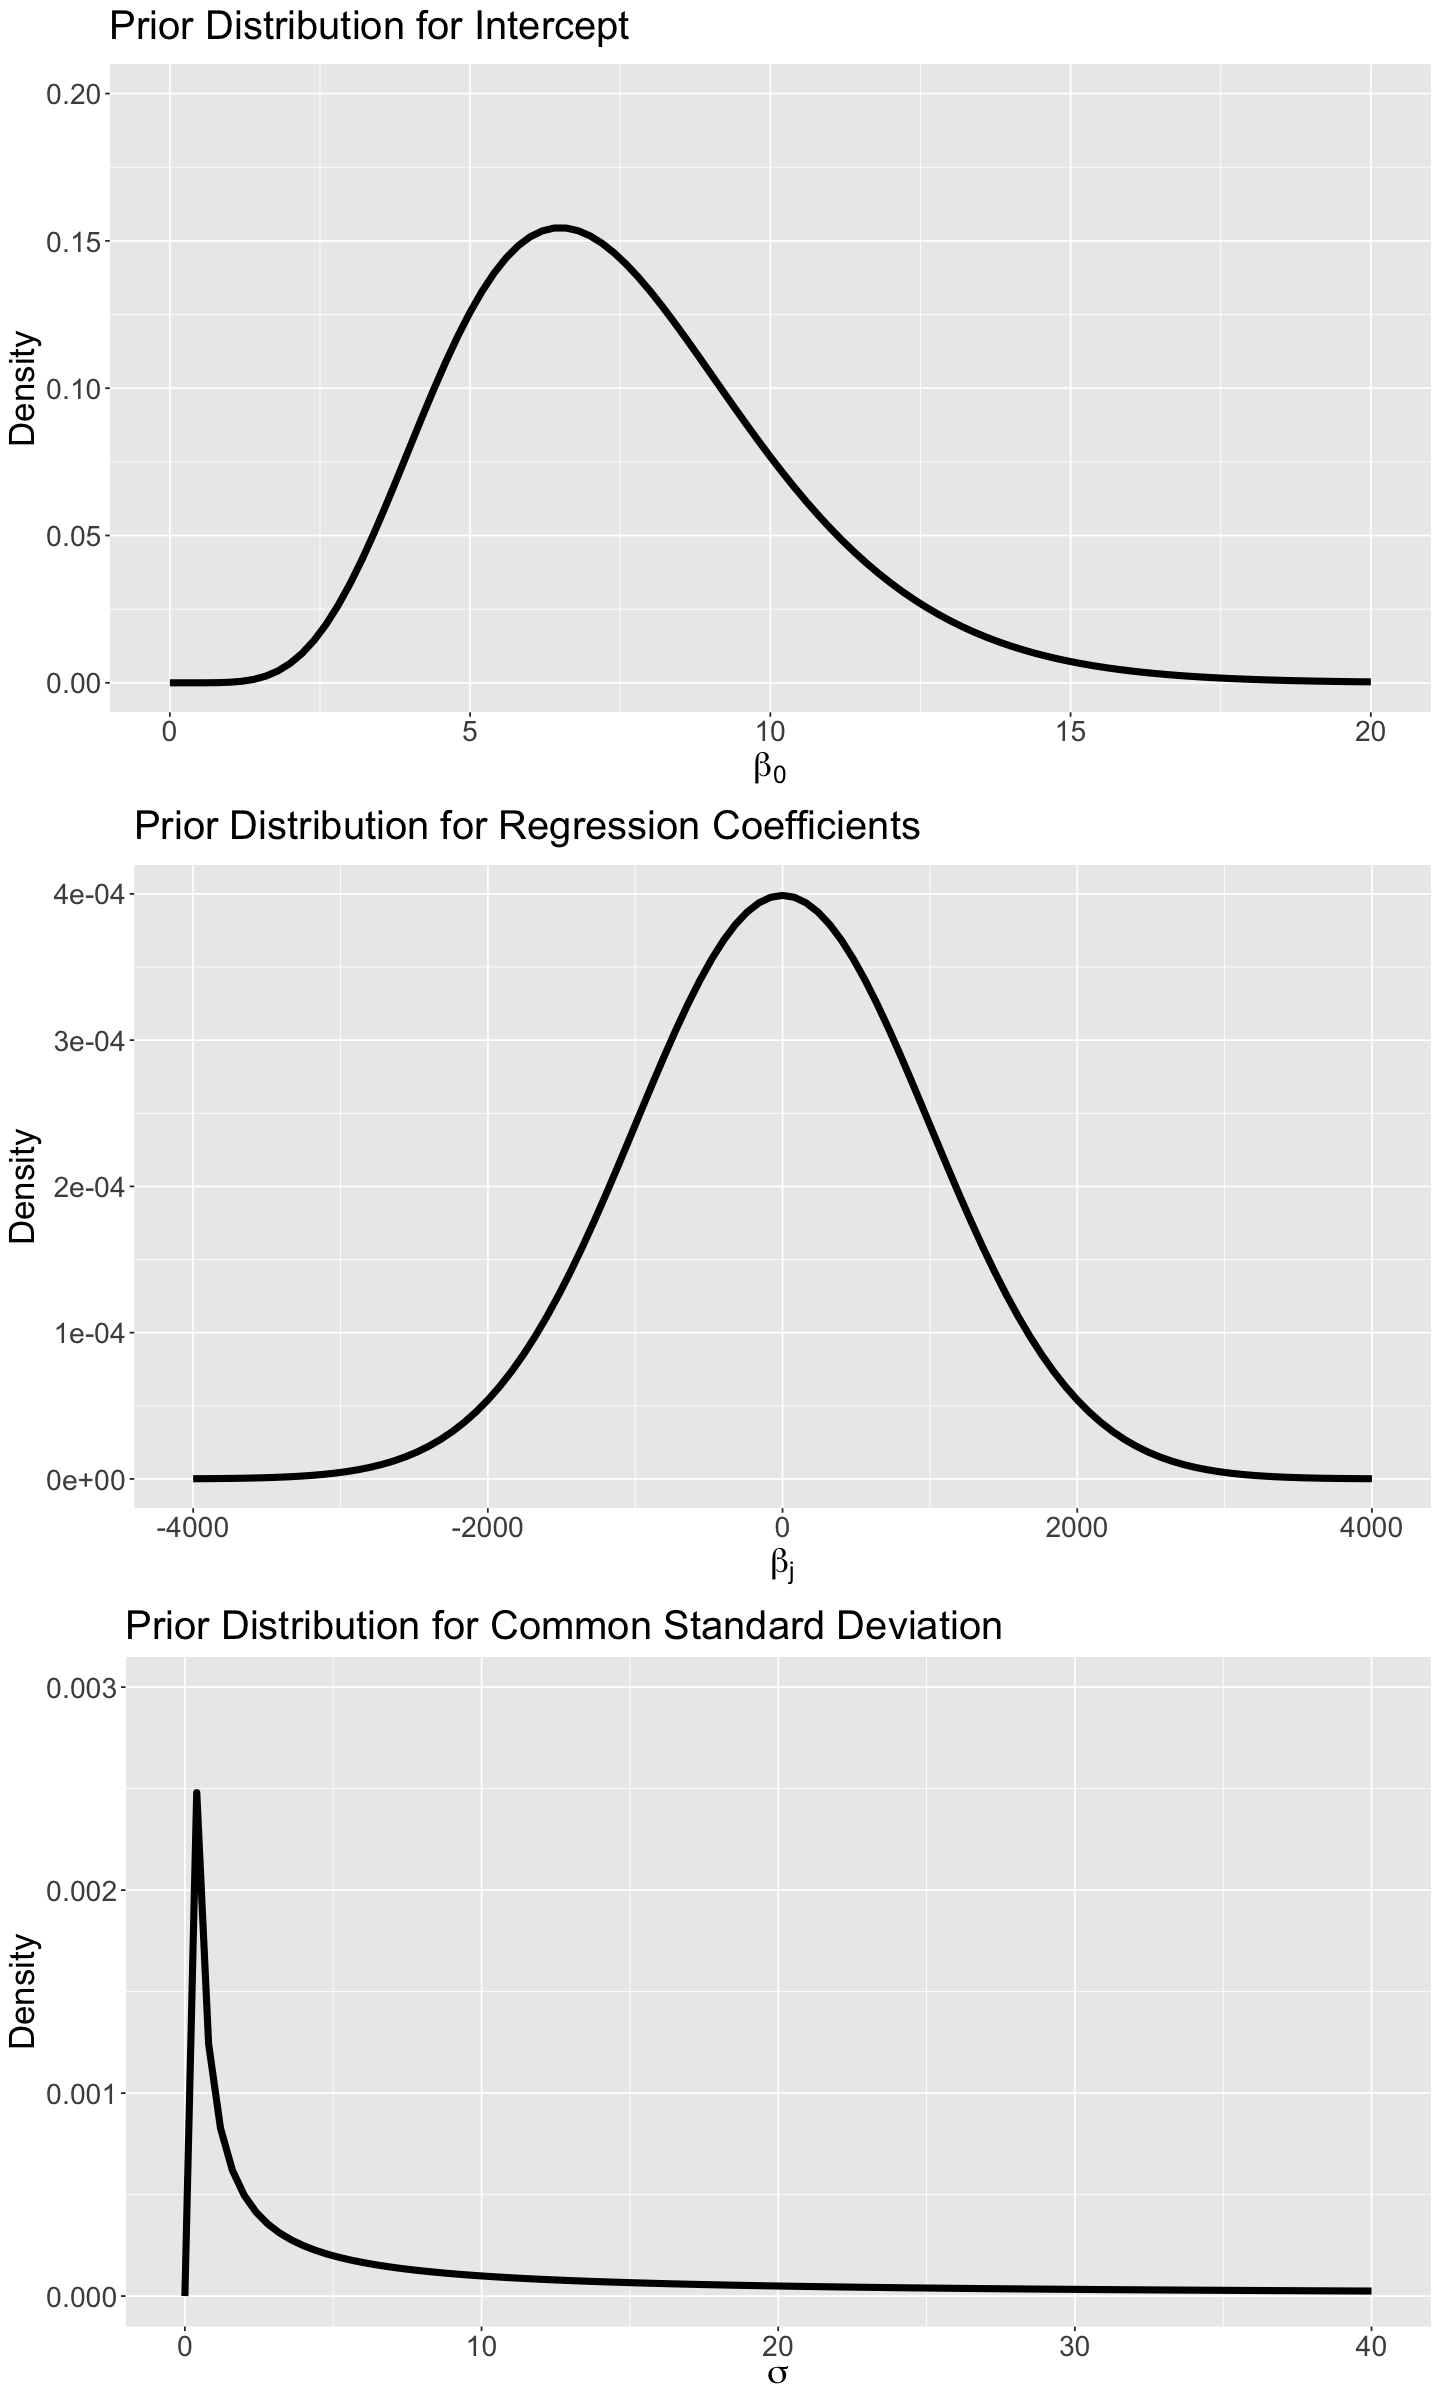

In [10]:
options(repr.plot.height = 20, repr.plot.width = 12)

plot_grid(prior_gamma_beta_0, prior_gamma_beta_j, prior_inverted_gamma_sigma_sq, nrow = 3)

Finally, we formalize the model with a dataset containing $n$ observations (i.e., rows in `bikes`), for the $i$th observation $(i = 1, \dots, n)$ with $Y_i$ `rides`, $X_{i,1}$ `temp_feel` and the dummy $X_{i,2}$ for `weekend`:

```{math}
\begin{align*}
\text{likelihood:} \qquad Y_i \mid \beta_0, \beta_1, \beta_2, \sigma^2 \mathop\sim^\text{ind} \mathcal{N} (\mu_i, \sigma^2) \\ \text{where} \quad \mu_i =  \beta_0 + \beta_1 X_{i, 1} + \beta_2 X_{i,2} \\
\text{priors:} \quad \beta_0 \sim \text{Gamma}(\alpha =  7.5, \beta = 1) \\
\beta_1 \sim \mathcal{N}(\mu_{\beta_1} = 0, \sigma_{\beta_1}^2 = 1000^2) \\
\beta_2 \sim \mathcal{N}(\mu_{\beta_2} = 0, \sigma_{\beta_1}^2 = 1000^2) \\
\sigma \sim \mathrm{IG}(\eta = 0.001, \lambda = 0.001).
\end{align*}
```

### 1.5.  Markov Chain Monte Carlo Simulation

**We proceed with the `Stan` code for this model**. We will continue using the blocks `data`, `parameters`, and `model`. 

Additionally, we introduce the block `generated_quantities`. **This block is executed after obtaining our posterior samples for the `parameters`.** The new block needs the variables `pred_x_1` and `pred_x_2` for the predictive inquiry for the weekend (`pred_x_2`) with 75 degrees Fahrenheit (`pred_x_1`). **We input these variables in `data`.**

```{important}
The block `generated_quantities` will create a **posterior predictive distribution `y_pred`** which takes into account two sources of variability:

- **Posterior variability in `parameters`:** We will generate one prediction by row from the Markov Chain Monte Carlo (MCMC) output to take into account this variability, i.e., the variability will come from our approximate joint posterior distribution. These predictions will be computed using the fixed values `pred_x_1` and `pred_x_2`.
- **Sampling variability:** Each prediction by row from the MCMC output should deviate from its respective **posterior prediction** (computed with the posterior sampled parameters). Thus, we will add random noise to it.

We are basically constructing a predictive distribution for the response for a weekend with 75 degrees Fahrenheit, from which we will compute an interval **analogous to the Prediction Interval (PI) from OLS**.
```

The block `generated quantities` takes the posterior samples of our parameters and computes $\mu_i$ with the fixed values `pred_x_1` and `pred_x_2`. Then, **we used a Normal random number generator `normal_rng()` to add the so-called random noise**.

In [11]:
bikerides_stan <- "data {
  int<lower=0> n;                               // training sample size
  vector[n] y;                                  // response vector
  vector[n] x_1;                                // regressor 1 vector
  vector[n] x_2;                                // regressor 2 vector
  real pred_x_1;                                // fixed value for regressor 1
  real pred_x_2;                                // fixed value for regressor 2
}
parameters {
  real<lower=0> beta_0;                         // intercept with lower bound
  real beta_1;                                  // regression coefficient 1
  real beta_2;                                  // regression coefficient 2
  real<lower=0> sigma;                          // common standard deviation with lower bound
  }
model {
  beta_0 ~ gamma(7.5, 1);                       // alpha = 7.5 and beta = 1
  beta_1 ~ normal(0, 1000);                     // mu_b1 = 0 and sigma_b1 = 1000
  beta_2 ~ normal(0, 1000);                     // mu_b2 = 0 and sigma_b2 = 1000
  sigma ~ inv_gamma(0.001, 0.001);              // eta = 0.001 and lambda = 0.001
  y ~ normal(beta_0 + beta_1 * x_1 + beta_2 * x_2, sigma);
}
generated quantities {
  real y_pred = normal_rng(beta_0 + beta_1 * pred_x_1 + beta_2 * pred_x_2, sigma);
}"

Next, we create a **dictionary** with all the `data` variables we need to pass into `Stan` as a `list()`. **We cannot pass logical values to `Stan` but `0`s and `1`s. Hence we use `model_matrix()` to convert column `weekend` to `0`s and `1`s.**

In [12]:
model_matrix <- as.data.frame(model.matrix(rides ~ temp_feel + weekend, data = bikeshare_data))
model_matrix

bikerides_dictionary <- list(
  n = nrow(bikeshare_data), 
  y = bikeshare_data$rides,
  x_1 = bikeshare_data$temp_feel,
  x_2 = model_matrix$weekendTRUE,
  pred_x_1 = 75,
  pred_x_2 = 1
)

,(Intercept),temp_feel,weekendTRUE
,<dbl>,<dbl>,<dbl>
1,1,64.72625,1
2,1,49.04645,0
3,1,51.09098,0
⋮,⋮,⋮,⋮
498,1,53.81600,1
499,1,52.85300,1
500,1,52.11383,0


Then, we compile the `Stan` model and run the simulation.

In [13]:
posterior_bikeshare <- stan(
  model_code = bikerides_stan,
  data = bikerides_dictionary,
  chains = 1,
  iter = 40000,
  warmup = 20000,
  thin = 60,
  seed = 553,
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 5.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 40000 [  0%]  (Warmup)
Chain 1: Iteration:  4000 / 40000 [ 10%]  (Warmup)
Chain 1: Iteration:  8000 / 40000 [ 20%]  (Warmup)
Chain 1: Iteration: 12000 / 40000 [ 30%]  (Warmup)
Chain 1: Iteration: 16000 / 40000 [ 40%]  (Warmup)
Chain 1: Iteration: 20000 / 40000 [ 50%]  (Warmup)
Chain 1: Iteration: 20001 / 40000 [ 50%]  (Sampling)
Chain 1: Iteration: 24000 / 40000 [ 60%]  (Sampling)
Chain 1: Iteration: 28000 / 40000 [ 70%]  (Sampling)
Chain 1: Iteration: 32000 / 40000 [ 80%]  (Sampling)
Chain 1: Iteration: 36000 / 40000 [ 90%]  (Sampling)
Chain 1: Iteration: 40000 / 40000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.16 seconds (Warm-up)
Chain 1:                1.897 seconds (Sampling)
Chain

### 1.6. Obtaining, Visualizing, and Interpreting the Posterior Results

**When comparing both outputs, Bayesian and OLS,** we highlight the following:

- Our nonnegative Bayesian intercept is **more precise** than the negative OLS estimation. 
- Moreover, the **point estimates** for $\beta_1$ differ greatly, but the Bayesian one is more precise (**check the posterior credible interval versus the frequentist 95% confidence interval**). 
- Regarding the **point estimates** for $\beta_2$, both approaches show considerable variability.
- Note that the **point estimates** for $\sigma$ are quite similar between both approaches!
- Finally, **both predictive intervals show high variability**.

In [14]:
# Bayesian posterior summaries!
tidy_posterior_bikeshare <- round(summary(posterior_bikeshare)$summary, 2)[-6, c("mean", "sd", "2.5%", "97.5%")]
tidy_posterior_bikeshare

,mean,sd,2.5%,97.5%
beta_0,7.50,2.76,3.15,14.11
beta_1,54.17,0.94,52.37,55.86
beta_2,-789.32,124.54,-1034.84,-543.73
sigma,1279.47,38.09,1208.41,1354.80
y_pred,3279.83,1332.33,640.81,5674.73


In [15]:
# Frequentist OLS output!
tidy(rides_OLS, conf.int = TRUE) |> 
  mutate_if(is.numeric, round, 3)
glance(rides_OLS) |> 
  mutate_if(is.numeric, round, 3)
predict.lm(rides_OLS, newdata = data.frame(temp_feel = 75, weekend = TRUE), interval = "prediction")

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1873.751,351.790,-5.326,0,-2564.929,-1182.573
temp_feel,80.347,4.971,16.162,0,70.580,90.115
weekendTRUE,-707.621,123.644,-5.723,0,-950.550,-464.693


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.38,0.378,1242.26,152.4,0,2,-4270.308,8548.617,8565.475,766974881,497,500


,fit,lwr,upr
1,3444.68,994.407,5894.953


Retaking our initial inquiries, we state the following:

> 1. *How are `weekend` and `temp_feel` associated with `rides`?*
> 2. *Is there a numerical result that can quantify this association?*

Our Bayesian estimates (i.e., **means of the MCMC posterior samples**) for $\beta_1$ and $\beta_2$ indicate that bike rides linearly increase by 54.20 on average for each degree Fahrenheit, whereas they decrease by 796.40 on average during weekends.

**Statistically, according to our 95% posterior credible intervals, the regression coefficients are different from zero (the intervals do not contain it).**

> 3. *Can we predict the number of `rides` during a weekend with 75 degrees Fahrenheit? What is the prediction interval?*

Yes, we can obtain a **Bayesian posterior predictive distribution** for a **95% prediction interval** of the number of `rides` during a weekend with 75 degrees Fahrenheit: 

$$(640.81, 5674.73).$$

Let us plot the aproximate posterior distribution for `temp_feel` ($\beta_1$):

In [16]:
options(repr.plot.height = 8, repr.plot.width = 12)

beta_1_post_dist <- mcmc_areas(posterior_bikeshare, pars = c("beta_1"), prob = 0.95) +
  theme(
    plot.title = element_text(size = 24, family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans")
  ) +
  labs(title = expression("Approximate Posterior Distribution and 95% Credible Interval for" ~ beta[1])) +
  xlab("Bikeshare Rides per °F")

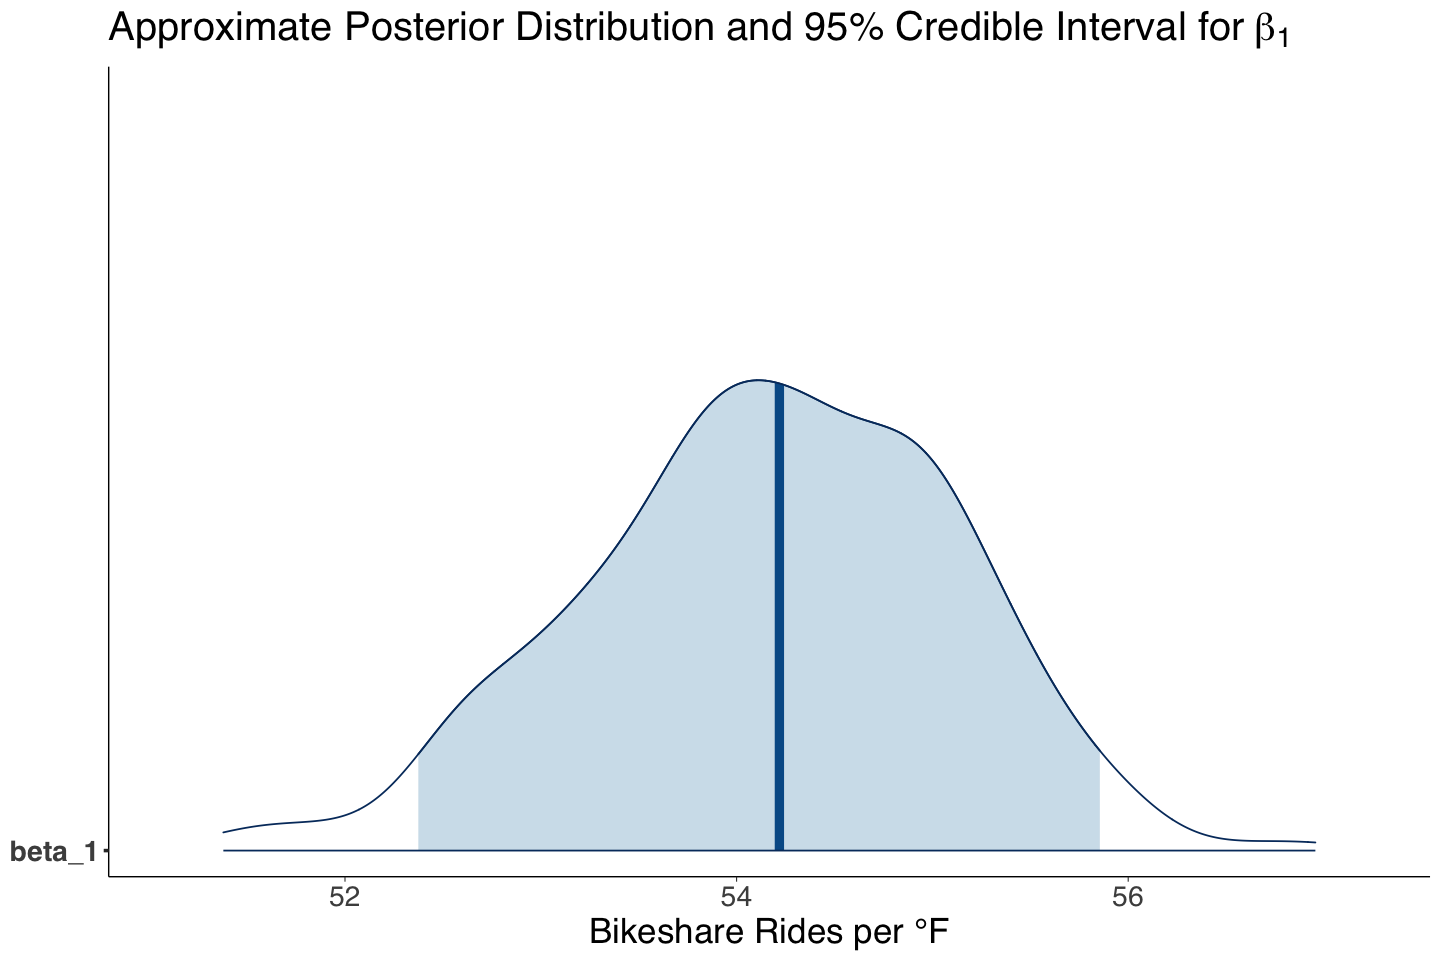

In [17]:
beta_1_post_dist

Now, we will do it for `weekend` ($\beta_2$):

In [18]:
beta_2_post_dist <- mcmc_areas(posterior_bikeshare, pars = c("beta_2"), prob = 0.95) +
  theme(
    plot.title = element_text(size = 24, family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans")
  ) +
  labs(title = expression("Approximate Posterior Distribution and 95% Credible Interval for" ~ beta[2])) +
  xlab("Bikeshare Rides Difference During Weekends Compared to Weekdays")

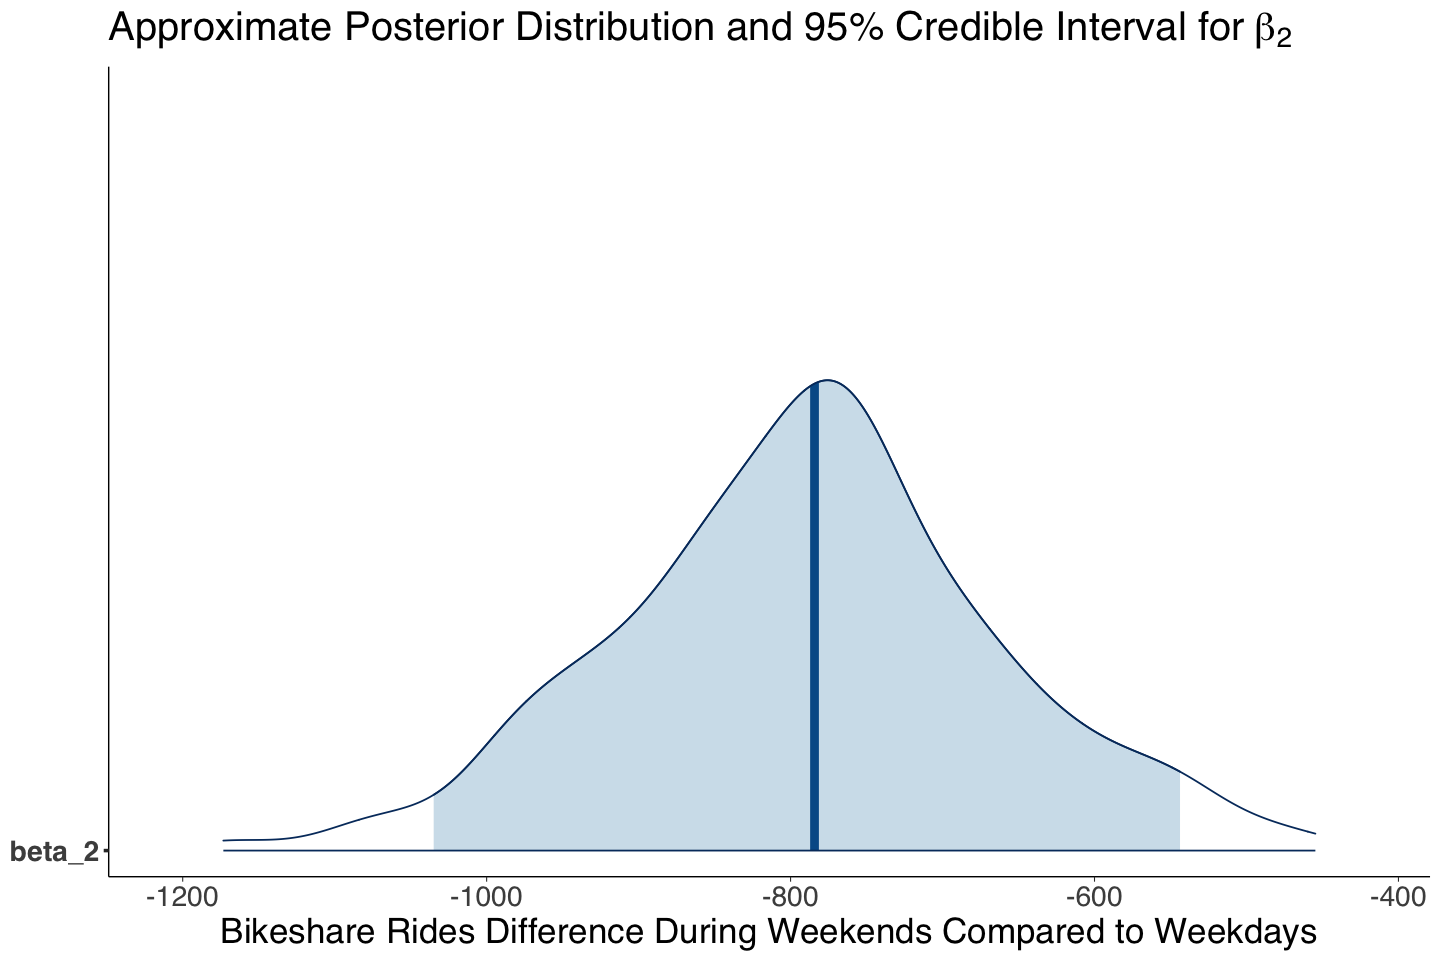

In [19]:
beta_2_post_dist

Then, we proceed with $\sigma$ (**the overall standard deviation between the observations**).

In [20]:
sigma_post_dist <- mcmc_areas(posterior_bikeshare, pars = c("sigma"), prob = 0.95) +
  theme(
    plot.title = element_text(size = 24, family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans")
  ) +
  labs(title = expression("Approximate Posterior Distribution and 95% Credible Interval for" ~ sigma)) +
  xlab("Bikeshare Rides")

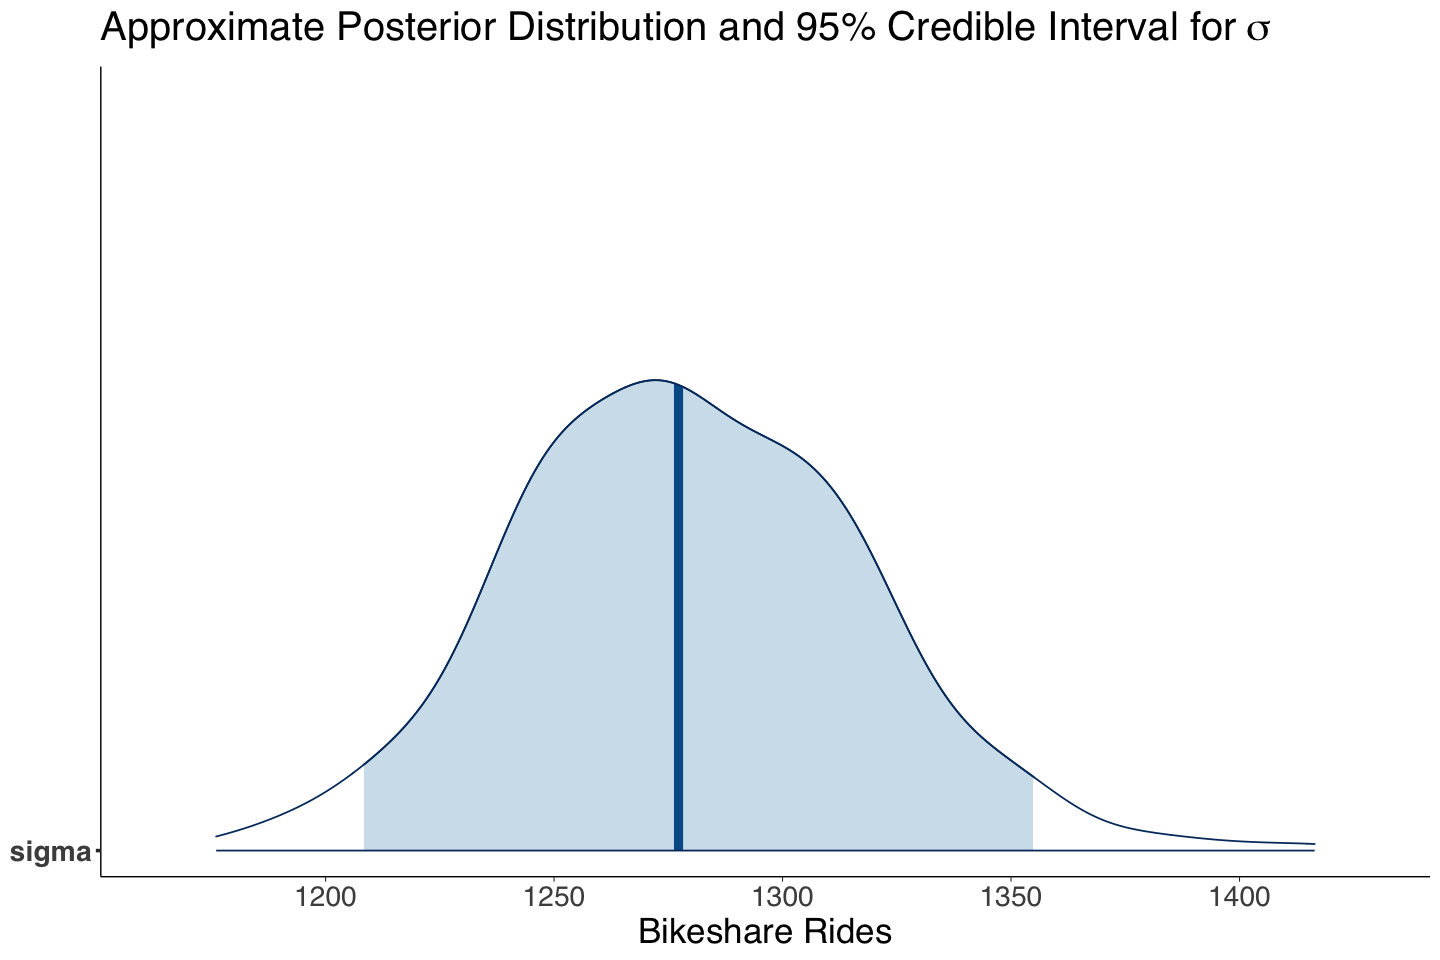

In [21]:
sigma_post_dist

And finally, the **95% prediction interval** of the number of `rides` during a weekend with 75°F.

In [22]:
PI_post_dist <- mcmc_areas(posterior_bikeshare, pars = c("y_pred"), prob = 0.95) +
  theme(
    plot.title = element_text(size = 24, family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans")
  ) +
  labs(title = "95% Response Prediction Interval During a Weekend and 75°F") +
  xlab("Bikeshare Rides")

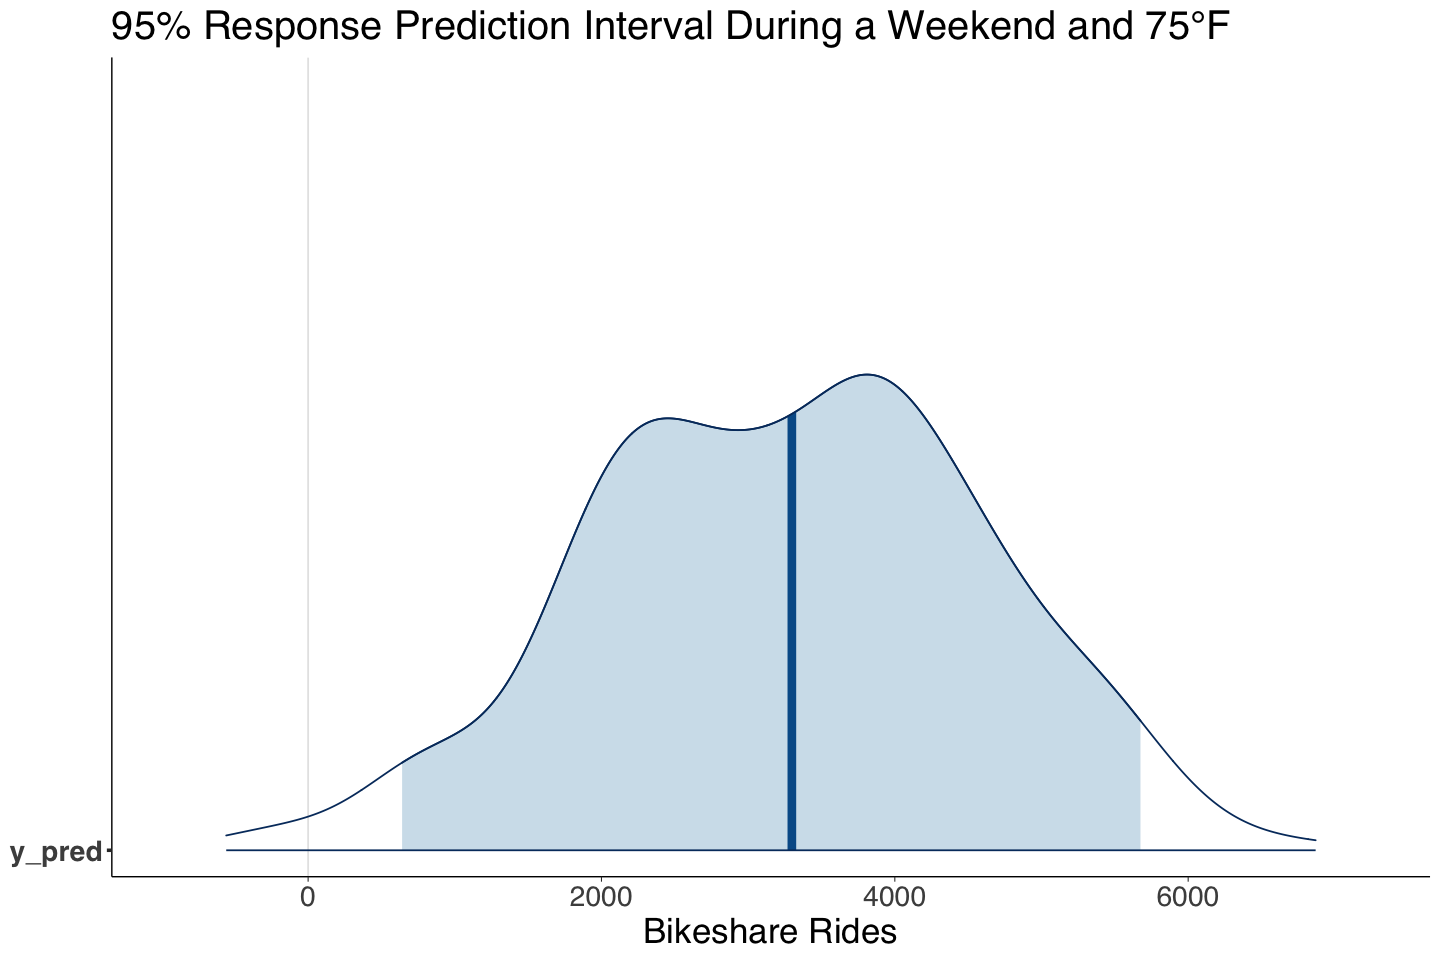

In [23]:
PI_post_dist

```{caution}
The 95% credible and the prediction intervals, show a critical concern: **large variability in MCMC sampling for $\beta_2$, $\sigma$, and the prediction interval**. These findings suggest the model is not capturing the right systematic component, i.e., the relation might be non-linear, and there might be other regressors we are missing.
```

## 2. The Tinder Example Comes Back

We have had enough bottle cap flips on this block. So let us retake a new Tinder example while applying what we learned in the theoretical Beta-Binomial model from {doc}`lecture3_beta_binomial_Bayesian_modelling`.

<center>        
<img src="https://logos-world.net/wp-content/uploads/2020/09/Tinder-Logo.png" width="300" height="170"/>
</center>

Again, **for the single population living in Vancouver looking for a partner**, let us suppose we want to make inference **on the probability $\pi$ of finding a partner when using Tinder**.

```{attention}
This Tinder example is a whole new problem with different data. In {doc}`lecture2_Bayes_MAP`, we were building the intuition of the Bayes' rule using Bernoulli distributions, without getting into Beta-Binomial terrains. But now, we can elaborate more formal Bayesian conclusions by using the Beta-Binomial model we saw in {doc}`lecture3_beta_binomial_Bayesian_modelling`.
```

Let us recall the Bayes' rule:

$$\text{posterior} \propto \text{prior} \times \text{likelihood}.$$

Hence, **via new Tinder data**, let us build our theoretical posterior before proceeding with Bayesian hypothesis testing.

### 2.1. The Prior

**We need to obtain our Beta prior for $\pi$.** Again, as an enthusiastic Tinder researcher in the literature, I collected information from 60 previous studies on using this app to find a partner. **These studies were run in cities as similar as Vancouver.**

Furthermore, in each study, there was a sample of single subjects. **All subjects were using Tinder in each sample.** The corresponding researchers recorded how many subjects ended up partnered in each study by using Tinder (the **success**).

```{warning}
Again, this is simulated data.
```

Let us recall the Bernoulli trial we used in {doc}`lecture3_beta_binomial_Bayesian_modelling`.

A **independent** subject $X_i$ is assumed as:

$$X_i \sim \mathrm{Bernoulli}(\pi) \quad \text{for} \quad i = 1, \dots, n.$$

- $\pi \in [0, 1]$ is the unknown parameter we want to infer: **the probability of finding a partner if we use Tinder**.
- $X_i$ is the result at the end of the study ($1 = \text{partnered}$ or $0 = \text{non-partnered}$).
- $X_i = 1$ is the **success** with probability $\pi$.
- $n$ is the sample size of each study.

Now, we need to set our theoretical Beta prior. I recorded the estimation results of $\pi$ in these 60 studies. It is stored in `tinder_prior_pi_studies`.

In [24]:
tinder_prior_pi_studies <- read_csv("../data/tinder_prior_pi_studies.csv", show_col_types = FALSE)
tinder_prior_pi_studies

tinder_prior_pi
<dbl>
0.2652300
0.3879204
0.2221071
⋮
0.3726435
0.2260178
0.2890508


Now, we obtain a histogram of `tinder_prior_pi_studies` (with the $y$-axis adjusted as a `after_stat(density)`).

In [25]:
hist_prior <- ggplot() +
  geom_histogram(
    data = tinder_prior_pi_studies,
    aes(x = tinder_prior_pi, y = after_stat(density)), fill = "grey", color = "blue", bins = 7, alpha = 0.3
  ) +
  ggtitle(expression(paste("Histogram of 60 Prior Estimations of ", pi))) +
  labs(y = expression(paste("f(", pi, ")")), x = expression(pi)) +
  theme(
    plot.title = element_text(size = 24),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) +
  coord_cartesian(xlim = c(0, 1))

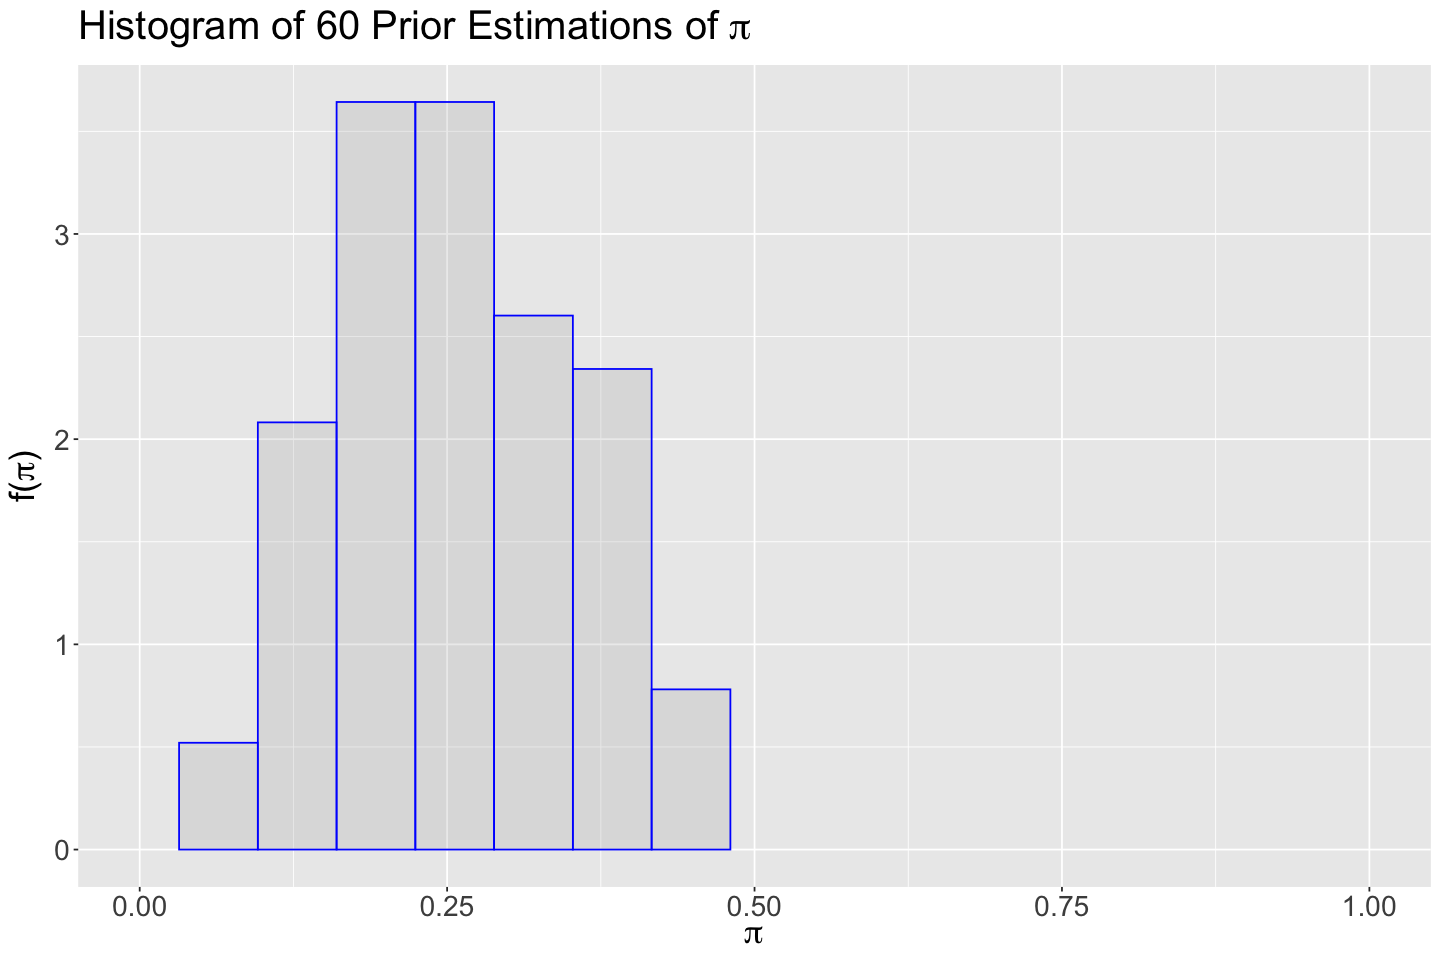

In [26]:
hist_prior

The histogram is right-skewed (a hint on the fact that, for the Beta prior, $a < b$). We can also obtain the summary statistics.

In [27]:
round(mean(tinder_prior_pi_studies$tinder_prior_pi), 3)
round(var(tinder_prior_pi_studies$tinder_prior_pi), 3)
round(sd(tinder_prior_pi_studies$tinder_prior_pi), 3)

[1] 0.255

[1] 0.01

[1] 0.098

Using the function `summarize_beta_binomial()`, let us obtain the theoretical values for $\text{Beta(a = 4, b = 12)}$.

In [28]:
summarize_beta_binomial(a = 4, b = 12)

Warning message in summarize_beta_binomial(a = 4, b = 12):
“To summarize the posterior, 
            specify data y and n”


model,alpha,beta,mean,mode,var,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
prior,4,12,0.25,0.2142857,0.01102941,0.105021


The summary statistics from `tinder_prior_pi_studies` are close to the theoretical prior metrics for $\text{Beta(a = 4, b = 12)}$. Hence, let us proceed with a Beta prior with hyperparameters $a = 4$ and $b = 12$.

```{caution}
Note this might not be the only choice. Given the right-skewness in the histogram of previous studies, we could select a different pair of hyperparameters as long as $a < b$ for our chosen theoretical Beta prior (**a frequentist [**goodness of fit test**](https://onlinelibrary.wiley.com/doi/full/10.1002/sta4.341) might be an appealing option too!**).
```

```{attention} 
Note that the histogram below has 8 bars for better visualization.
```

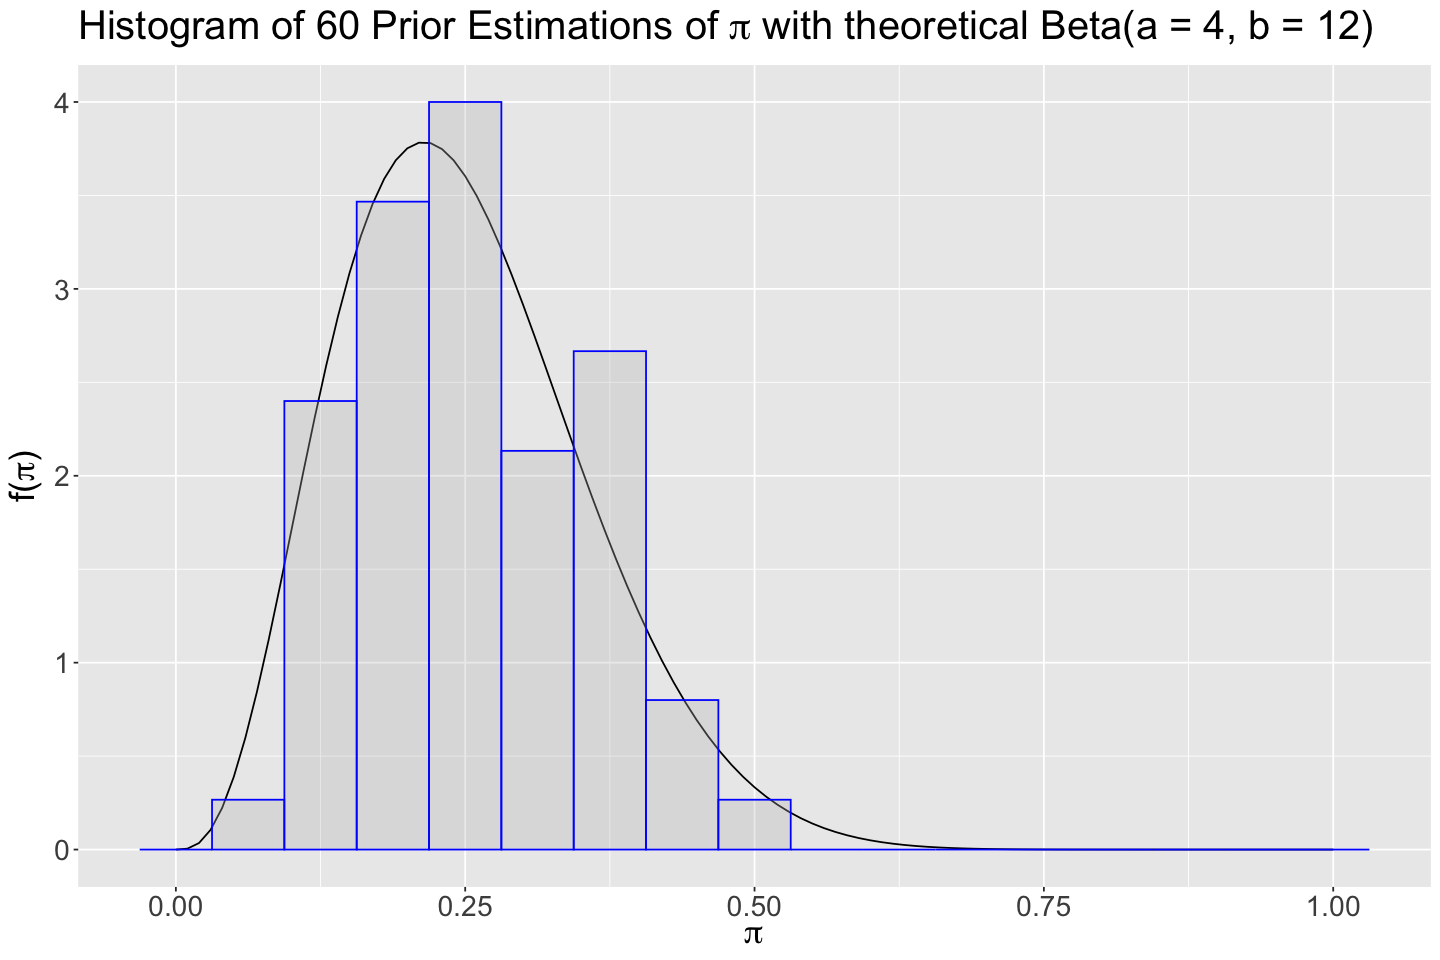

In [29]:
hist_prior <- plot_beta(4, 12) +
  geom_histogram(
    data = tinder_prior_pi_studies,
    aes(x = tinder_prior_pi, y = after_stat(density)), fill = "grey", color = "blue", bins = 17, alpha = 0.3
  ) +
  ggtitle(expression(paste("Histogram of 60 Prior Estimations of ", pi, " with theoretical Beta(a = 4, b = 12)"))) +
  labs(y = expression(paste("f(", pi, ")")), x = expression(pi)) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  )
hist_prior

We decided to use this prior:

$$\pi \sim \text{Beta}(a = 4, b = 12).$$

### 2.2. The Likelihood

We ran our Tinder study in Vancouver with $n = 200$ subjects, all of them used Tinder. **At the end of the study, 20 of them ended up partnered by using Tinder.**

The Beta-Binomial model is set up as follows:

$$X_i \sim \text{Bernoulli}(\pi) \quad \text{with ending up partnered as success}$$

$$Y = \sum_{i = 1}^n X_i$$

```{math}
\begin{gather*}
Y \mid \pi \sim \text{Binomial}(n = 200, \pi) \\
\pi \sim \text{Beta}(a = 4, b = 12).
\end{gather*}
```

### 2.3. The Posterior

We previously derived **the exact Beta posterior** for $\pi$ with the Beta-Binomial model:

$$\pi \mid Y = y \sim \text{Beta}(a' = a + y, b' = b + n - y).$$

Since $a = 4$, $b = 12$, $n = 200$, and $y = 20$; then we have:

$$\pi \mid Y = y \sim \text{Beta}(a' = 24, b' = 192).$$

Now, we can get the theoretical prior and posterior metrics.

In [30]:
summarize_beta_binomial(a = 4, b = 12, y = 20, n = 200)

model,alpha,beta,mean,mode,var,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
prior,4,12,0.2500000,0.2142857,0.0110294118,0.10502101
posterior,24,192,0.1111111,0.1074766,0.0004551402,0.02133402


Finally, we plot the prior, likelihood, and posterior.

In [31]:
plot_comparison <- plot_beta_binomial(a = 4, b = 12, y = 20, n = 200) +
  labs(y = "Density", x = expression(pi)) +
  ggtitle("Comparison of Prior, Likelihood, and Posterior") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.text = element_text(size = 21, margin = margin(r = 1, unit = "cm")),
  )

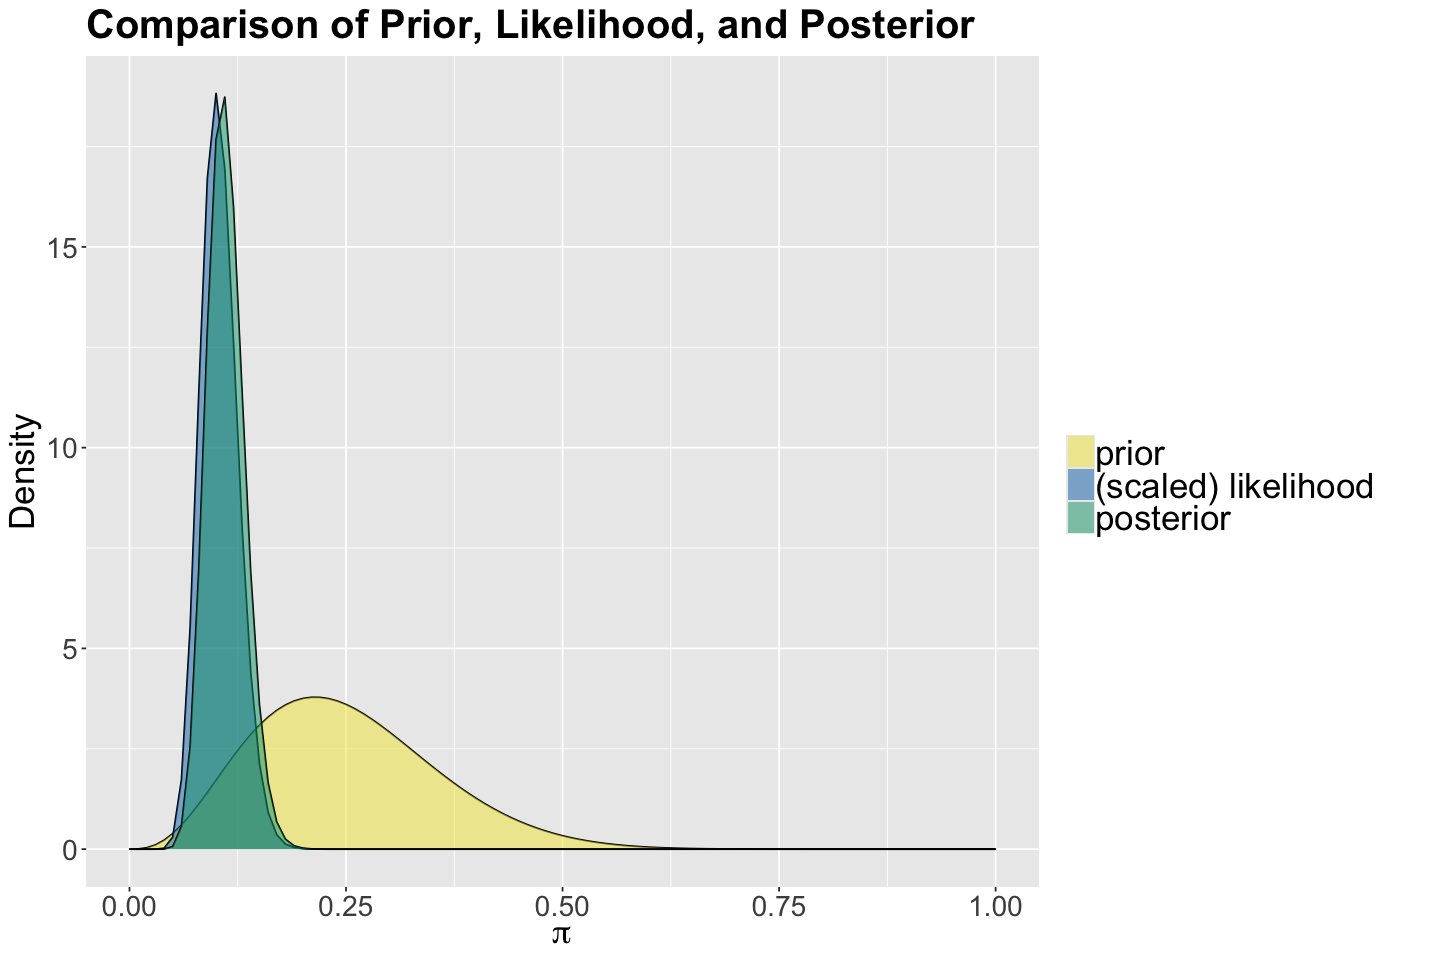

In [32]:
plot_comparison

We updated our prior information, along with our own evidence, to get our Beta posterior. Note the small variability associated to the posterior $\pi$ (**less uncertainty!**). 

Let us obtain a 95% posterior credible interval for $\pi$.

In [33]:
round(qbeta(c(0.025, 0.975), 24, 192), 2)

[1] 0.07 0.16

 We can also plot this **posterior** 95% credible interval via `plot_beta_ci()` from `bayesrules`.

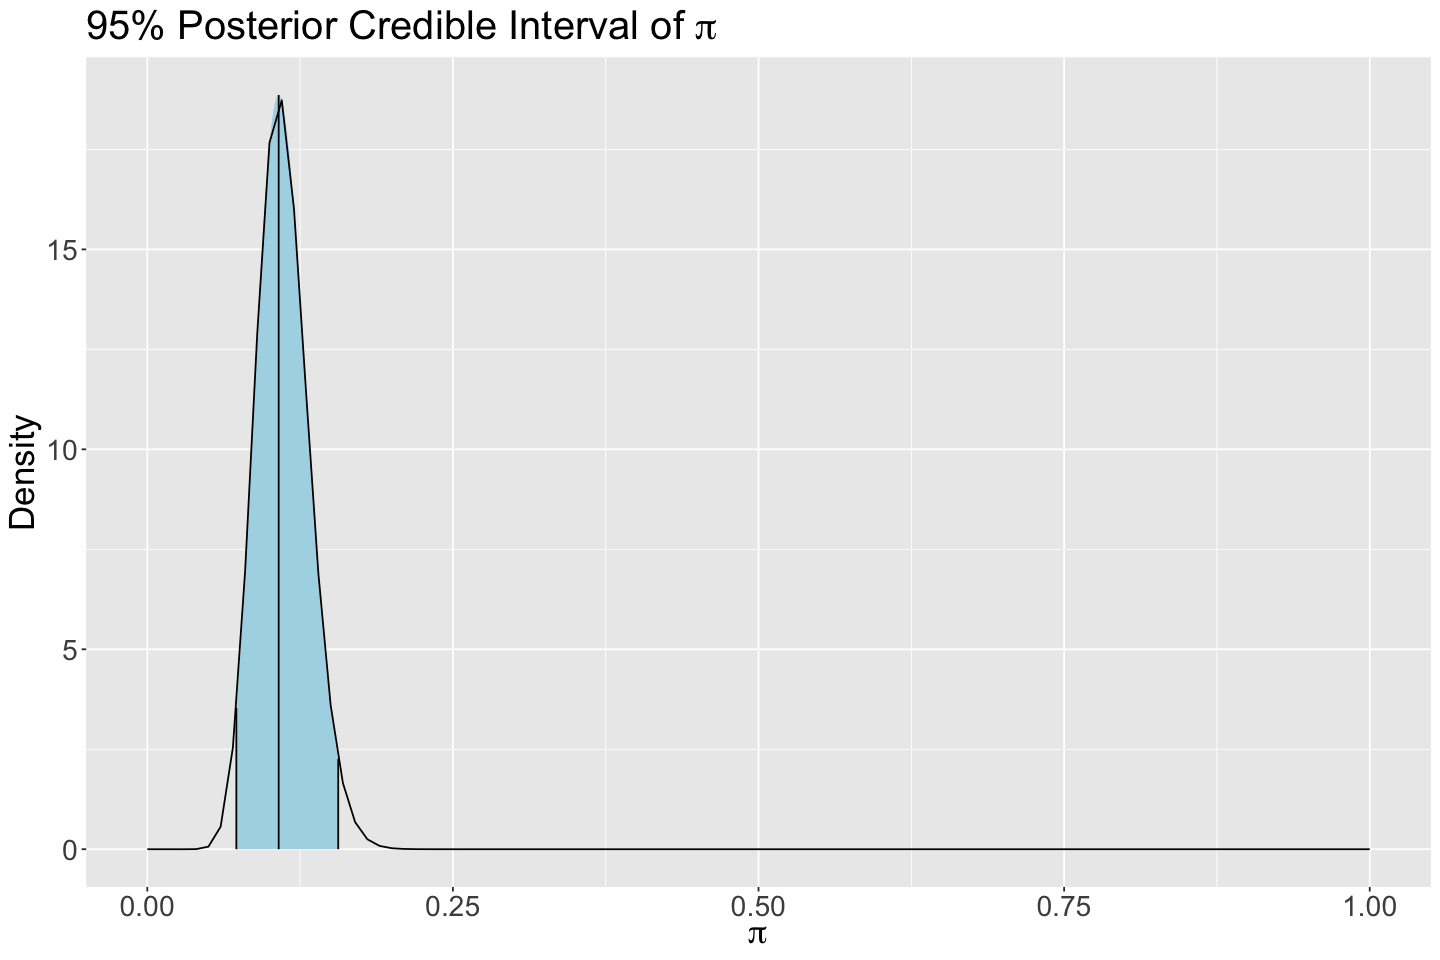

In [34]:
posterior_CI <- plot_beta_ci(24, 192, ci_level = 0.95) +
  ggtitle(expression(paste("95% Posterior Credible Interval of ", pi))) +
  labs(y = "Density", x = expression(pi)) +
  theme(
    plot.title = element_text(size = 24),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  )
posterior_CI

## 3. Bayesian Hypothesis Testing

### 3.1. One-Sided Test

**We have not interpreted our posterior results yet!** We could do so via the 95% posterior credible interval. Nonetheless, we will try a different approach to make inference by using our theoretical Beta posterior. For example, suppose another researcher claims the following:

> *In any city like Vancouver, more than 15% of the single people who use the Tinder app will eventually find a partner.*

We could assess this statement by using our Bayesian results! 

**How do we do it?** Bayesian hypothesis testing comes to the rescue. As in the case of frequentist statistics, we will have two hypotheses for $\pi$: **null** $(H_0)$ and **alternative** $(H_a)$.

$$H_0: \pi \leq 0.15$$
$$H_a: \pi > 0.15.$$

The alternative hypothesis is associated with the researcher's claim, whereas the null will be the opposite.

**Here comes the Bayesian twist.** Unlike frequentist statistics, each hypothesis will have a probability associated with the previously obtained Beta posterior. So, **how do we get these probabilities?** We can simply use `pbeta()`. Moreover, let us plot these probabilities for a better understanding.

```{important}
Recall the Beta posterior of $\pi$ is a probability over probabilities.
```

Let $f(\pi \mid y = 20)$ be the posterior $\text{Beta}(a' = 24, b' = 192)$ probability density function (PDF).

Firstly, for 

$$H_0: \pi \leq 0.15;$$

its posterior probability will be given by:

$$P(\pi \leq 0.15 \mid Y = 20) = \int_{0}^{0.15} f(\pi \mid y = 20) \,d\pi = 0.957.$$

In [35]:
posterior_prob_H_0 <- pbeta(0.15, 24, 192)
round(posterior_prob_H_0, 3)

[1] 0.957

Now, for the alternative

$$H_a: \pi > 0.15;$$

its posterior probability will be given by:

$$P(\pi > 0.15 \mid Y = 20) = \int_{0.15}^{1} f(\pi \mid y = 20) \,d\pi = 0.043.$$

In [36]:
posterior_prob_H_a <- pbeta(0.15, 24, 192, lower.tail = FALSE)
round(posterior_prob_H_a, 3)

[1] 0.043

Therefore, the associated posterior probability to $H_0$ is 0.957 and 0.043 for $H_a$ (the complement!). The plots for the Beta posterior show these areas. **Note a vertical red line crosses $\pi = 0.15$ on the $x$-axes.**

In [37]:
# Modified code, from bayesrules, to plot the posterior probabilities of H_0 and H_a.

plot_posterior_prob_H_0 <- ggplot(data.frame(x = c(0, 1)), aes(x = x)) +
  stat_function(
    fun = dbeta,
    args = list(24, 192),
    xlim = c(0, 0.15),
    geom = "area",
    fill = "lightblue"
  ) +
  stat_function(
    fun = dbeta,
    args = list(24, 192)
  ) +
  geom_vline(xintercept = 0.15, colour = "darkred", linewidth = 2) +
  ggtitle("Posterior Prob. of Null Hypothesis (Blue Area)") +
  labs(y = "Density", x = expression(pi)) +
  theme(
    plot.title = element_text(size = 14.5, face = "bold"),
    axis.text = element_text(size = 14.5),
    axis.title = element_text(size = 14.5)
  ) +
  xlim(0, 1) +
  ylim(0, 20)

plot_posterior_prob_H_a <- ggplot(data.frame(x = c(0, 1)), aes(x = x)) +
  stat_function(
    fun = dbeta,
    args = list(24, 192),
    xlim = c(0.15, 1),
    geom = "area",
    fill = "lightgreen"
  ) +
  stat_function(
    fun = dbeta,
    args = list(24, 192)
  ) +
  geom_vline(xintercept = 0.15, colour = "darkred", linewidth = 2) +
  ggtitle("Posterior Prob. of Alternative Hypothesis (Green Area)") +
  labs(y = "Density", x = expression(pi)) +
  theme(
    plot.title = element_text(size = 14.5, face = "bold"),
    axis.text = element_text(size = 14.5),
    axis.title = element_text(size = 14.5)
  ) +
  xlim(0, 1) +
  ylim(0, 20)

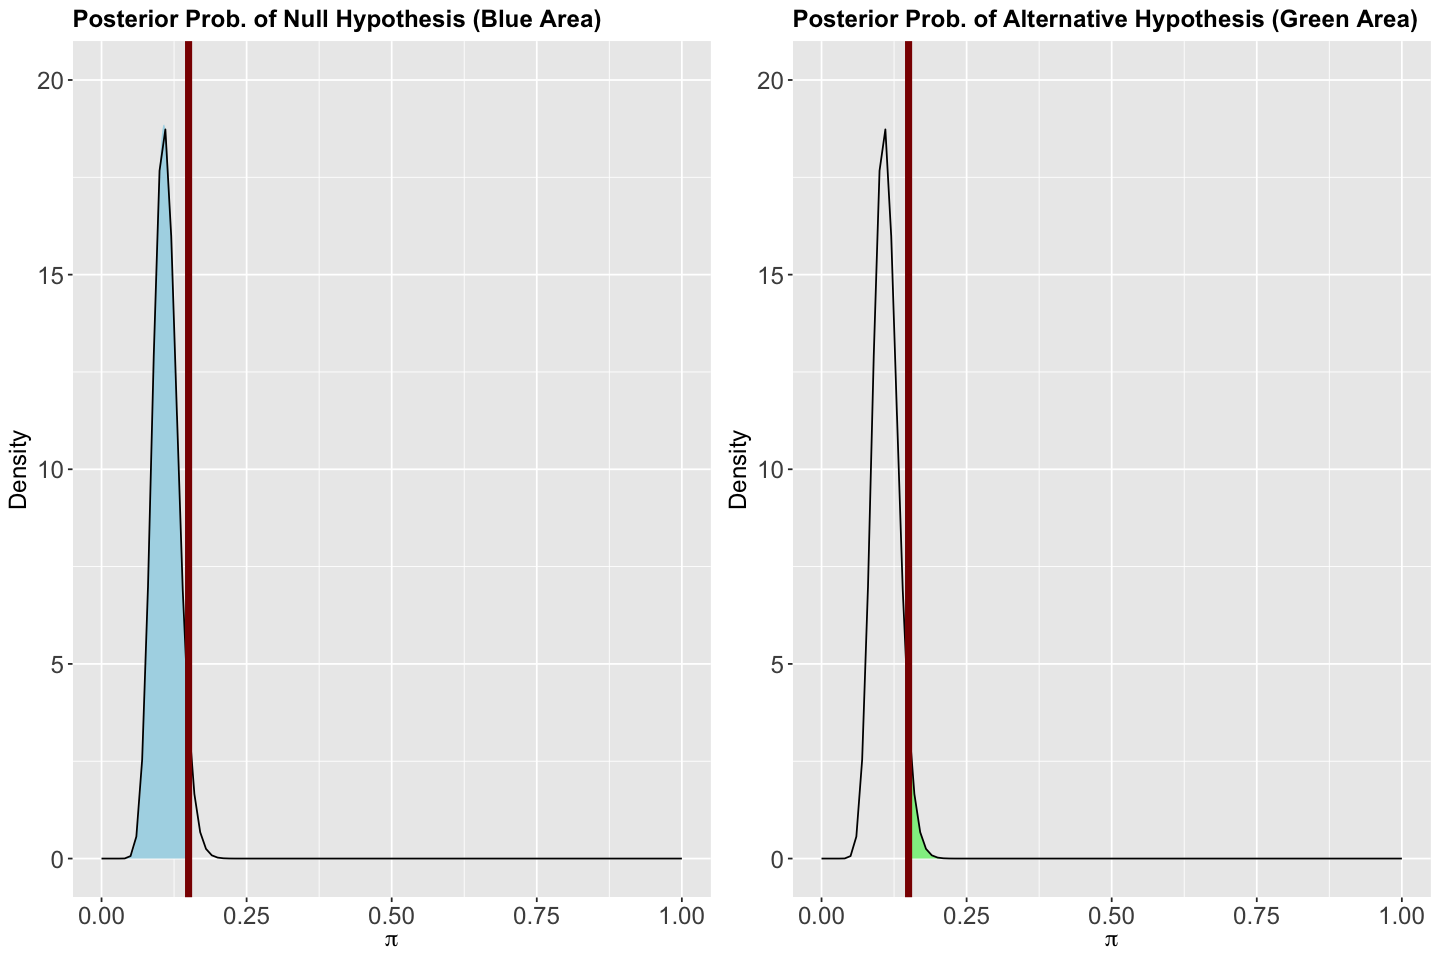

In [38]:
plot_grid(plot_posterior_prob_H_0, plot_posterior_prob_H_a)

Summarizing, we have two **posterior probabilities**:

$$P(H_0 \mid Y = 20) = P(\pi \leq 0.15 \mid Y = 20) = 0.957$$
$$P(H_a \mid Y = 20) = P(\pi > 0.15 \mid Y = 20) = 0.043.$$

Now, we can compute the **posterior odds** that $\pi > 0.15$:

$$\text{posterior odds} = \frac{P(H_a \mid Y = 20)}{P(H_0 \mid Y = 20)} = \frac{0.043}{0.957} = 0.045.$$

In [39]:
posterior_odds <- posterior_prob_H_a / posterior_prob_H_0
round(posterior_odds, 3)

[1] 0.045

**How can we interpret this ratio?** We can state that $\pi$ is 22.22 times $\big(\frac{1}{0.045}\big)$ more likely to be less or equal than 0.15 compared to being above 0.15 using our **posterior model**.

In Bayesian hypothesis testing, we do not use $p$-values. However, there is an analogous metric called the **Bayes factor**. This factor will compare the **posterior odds** versus the **prior odds**. It will shed light on how our inference on $\pi$ changed given our observed evidence (reflected in the posterior distribution via the Bayes' rule).

We already computed the **posterior odds**, let us proceed with the **prior odds**. Let $f(\pi)$ be the prior $\text{Beta}(a = 4, b = 12)$ PDF. 

For 

$$H_0: \pi \leq 0.15;$$

its prior probability will be given by:

$$P(\pi \leq 0.15) = \int_{0}^{0.15} f(\pi) \,d\pi = 0.177.$$

In [40]:
prior_prob_H_0 <- pbeta(0.15, 4, 12)
round(prior_prob_H_0, 3)

[1] 0.177

Now, for the alternative

$$H_a: \pi > 0.15;$$

its prior probability will be given by:

$$P(\pi > 0.15) = \int_{0.15}^{1} f(\pi) \,d\pi = 0.823.$$

In [41]:
prior_prob_H_a <- pbeta(0.15, 4, 12, lower.tail = FALSE)
round(prior_prob_H_a, 3)

[1] 0.823

Thus, the associated prior probability to $H_0$ is 0.177 and 0.823 for $H_a$ (the complement!). The plots for the Beta prior show these areas. **Note a vertical red line crosses $\pi = 0.15$ on the $x$-axes.**

In [42]:
# Modified code, from bayesrules, to plot the posterior probabilities of H_0 and H_a.

plot_prior_prob_H_0 <- ggplot(data.frame(x = c(0, 1)), aes(x = x)) +
  stat_function(
    fun = dbeta,
    args = list(4, 12),
    xlim = c(0, 0.15),
    geom = "area",
    fill = "lightblue"
  ) +
  stat_function(
    fun = dbeta,
    args = list(4, 12)
  ) +
  geom_vline(xintercept = 0.15, colour = "darkred", linewidth = 2) +
  ggtitle("Prior Prob. of Null Hypothesis (Blue Area)") +
  labs(y = "Density", x = expression(pi)) +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 14)
  ) +
  xlim(0, 1) +
  ylim(0, 20)

plot_prior_prob_H_a <- ggplot(data.frame(x = c(0, 1)), aes(x = x)) +
  stat_function(
    fun = dbeta,
    args = list(4, 12),
    xlim = c(0.15, 1),
    geom = "area",
    fill = "lightgreen"
  ) +
  stat_function(
    fun = dbeta,
    args = list(4, 12)
  ) +
  geom_vline(xintercept = 0.15, colour = "darkred", linewidth = 2) +
  ggtitle("Prior Prob. of Alternative Hypothesis (Green Area)") +
  labs(y = "Density", x = expression(pi)) +
  theme(
    plot.title = element_text(size = 14.5, face = "bold"),
    axis.text = element_text(size = 14.5),
    axis.title = element_text(size = 14.5)
  ) +
  xlim(0, 1) +
  ylim(0, 20)

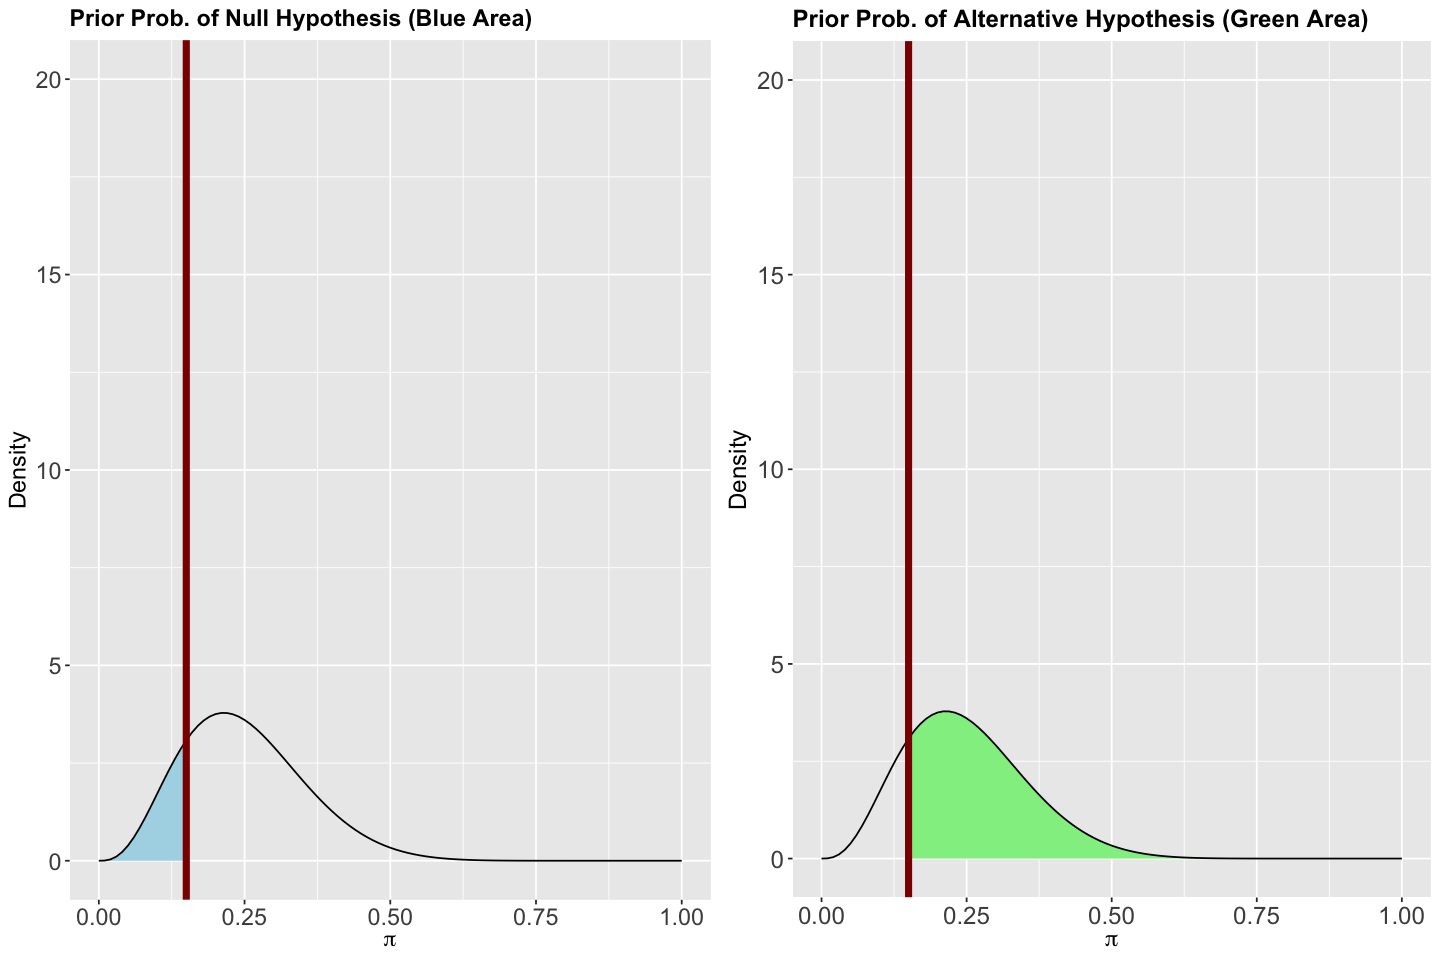

In [43]:
plot_grid(plot_prior_prob_H_0, plot_prior_prob_H_a)

Summarizing, we have two prior probabilities:

$$P(H_0) = P(\pi \leq 0.15) = 0.177$$
$$P(H_a) = P(\pi > 0.15) = 0.823.$$

We can compute the **prior odds** that $\pi > 0.15$:

$$\text{prior odds} = \frac{P(H_a)}{P(H_0)} = \frac{0.823}{0.177} = 4.639.$$

In [44]:
prior_odds <- prior_prob_H_a / prior_prob_H_0
round(prior_odds, 3)

[1] 4.639

**How can we interpret this ratio?** We can state that $\pi$ is 4.639 times more likely to be above 0.15 compared to being less or equal than 0.15 using our prior model.

The **Bayes factor** is computed as follows:

$$\text{Bayes Factor} = \frac{\text{posterior odds}}{\text{prior odds}} = 0.01.$$

In [45]:
bayes_factor <- posterior_odds / prior_odds
round(bayes_factor, 2)

[1] 0.01

```{admonition} How can we interpret the Bayes factor?
:class: hint
In general, there are three possible scenarios:

- $\text{Bayes Factor} = 1$: The plausibility of $H_a$ remained the same, even though we collected new evidence (our study) and applied the Bayes' rule.
- $\text{Bayes Factor} > 1$: The plausibility of $H_a$ increased once we have collected more evidence (our study) and applied the Bayes' rule.
- $\text{Bayes Factor} < 1$: The plausibility of $H_a$ decreased once we have collected more evidence (our study) and applied the Bayes' rule.
```

**Therefore, the researcher's statement is less plausible in the light of our own evidence!**

```{exercise}
:label: lecture5-q2

Suppose you want to apply the previous hypothesis testing procedure using the approximate posterior samples from MCMC. Hence, there is no analytical solution to the corresponding integrals to obtain the probabilities associated with the posterior odds. Actually, we do not even have an exact PDF to integrate!

**What workaround can you use in that regard to obtain the posterior odds?**
```

### 3.2. Two-Sided Test

Now let us suppose the researcher only wants to assess whether or not 15% of the single people who use the Tinder app will eventually find a partner (in any city like Vancouver). This is a two-sided test:

$$H_0: \pi = 0.15$$
$$H_a: \pi \neq 0.15.$$

However, in a continuous parameter like $\pi$, there is a problem:

$$P(\pi = 0.15 \mid Y = 20) = \int_{0.15}^{0.15} f(\pi \mid y = 20) \,d\pi = 0.$$

**We cannot obtain the posterior odds!** And forget about the prior odds (it is the same problem).

There is a tweak to solve this two-sided test, we can restate our hypotheses as some range of plausible values ($\pm 0.10$, for instance):

$$H_0: \pi \in (0.05, 0.25)$$
$$H_a: \pi \notin (0.05, 0.25).$$

**And let us use our 95% posterior credible interval to evaluate this test:**

In [46]:
round(qbeta(c(0.025, 0.975), 24, 192), 2)

[1] 0.07 0.16

This credible interval falls within the hypothesized range in $H_0$. **Therefore, we have reasonable posterior evidence in favour of $H_0$ with 95% probability!**

## 4. Wrapping Up

- We can extend the Bayesian paradigm to a regression framework where the systematic component will become part of our likelihood.
- The use of priors on our regression parameters of interest allows us to make more clever modelling (i.e., choosing the right support for our parameters). Nonetheless, obtaining prior knowledge can be a challenging task.
- `Stan` is a powerful tool that will even allow us to estimate non-linear regression models using MCMC. Moreover, the algorithm is the same for all the regression approaches!
- Bayesian hypothesis testing has a framework for assigning probabilities to our hypotheses based on our prior and posterior models.
- The Bayes Factor is the substitute to $p$-value in hypothesis testing.